<a href="https://colab.research.google.com/github/mzaoualim/cryptocurrency_portfolio_optimization_app/blob/main/crypto_portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance --quiet
!pip install yahooquery --quiet
!pip install requests_html --quiet
!pip install ydata_profiling --quiet
!pip install PyPortfolioOpt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Modules imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from yahooquery import Screener
import requests
from requests_html import HTMLSession
from datetime import datetime
from ydata_profiling import ProfileReport
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

# The goal
Inspired by the G-Reseach competition in [Kaggle](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview) and [this portfolio optimizer tool](https://www.portfoliovisualizer.com/optimize-portfolio)

our goal is to Create a Streamlit App to generate, for a given:
  - porfolio of cryptocurrencies.
  - Budget.
  - Investements withdrawal horizon.

The optimized ratio of chosen currencies with the predicted profits.

# The Data
We'll start with a selection of 3 most popular crypto currencies on the market by market capitalization.

## Getting Data

For scraping historical trading data of the crypto currencies, we rely on Yahoo! finance API.
Fortunatly there is a python [project](https://pypi.org/project/yfinance/) who offers an easy pythonic way to get data.

In [3]:
# Scraping list of 3 most popular crypto tickets (cc)

session = HTMLSession()
num_currencies=3
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
cc = df.Symbol.tolist()
cc

['BTC-USD', 'ETH-USD', 'USDT-USD']

In [4]:
# For the given cryptocurrencies, we grab max available histrical closing price data:

tickers = yf.Tickers(cc)
end_date = datetime.now().strftime('%Y-%m-%d')
data = tickers.history(period='max',end=end_date,interval='1d')['Close']
data

[*********************100%***********************]  3 of 3 completed


,BTC-USD,ETH-USD,USDT-USD
Date,,,
2014-09-17,457.334015,NaN,NaN
2014-09-18,424.440002,NaN,NaN
2014-09-19,394.795990,NaN,NaN
2014-09-20,408.903992,NaN,NaN
2014-09-21,398.821014,NaN,NaN
...,...,...,...
2023-03-02,23475.466797,1647.319336,1.000091
2023-03-03,22362.679688,1569.167603,1.000100
2023-03-04,22353.349609,1566.923950,1.000114


## Preprocessing Data

In [5]:
# missing data
data.isna().sum()

BTC-USD        0
ETH-USD     1149
USDT-USD    1149
dtype: int64

In [6]:
# data length before removing missing data
len(data)

3093

In [7]:
# after removing row with missing obs
data = data.dropna(axis=0)
len(data)

1944

These missing data are caused by differences in starting dates of trading of each currency.

In [8]:
data.isna().sum()

BTC-USD     0
ETH-USD     0
USDT-USD    0
dtype: int64

In [9]:
data.dtypes

BTC-USD     float64
ETH-USD     float64
USDT-USD    float64
dtype: object

In [11]:
# Save data to csv for future manipulations
data.to_csv('data')

# EDA

## Pandas Profiling

In [12]:
# Trying  ydata-profiling 
profile = ProfileReport(data, tsmode=True)

In [13]:
# display report in ipnb friendly manner!
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
# display report in ipynb friendly manner
# widget?


In [14]:
profile.to_widgets()

/usr/local/lib/python3.8/dist-packages/ydata_profiling/profile_report.py:495: UserWarning: Ipywidgets is not yet fully supported on Google Colab (https://github.com/googlecolab/colabtools/issues/60).As an alternative, you can use the HTML report. See the documentation for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
profile

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation Analysis

## Volatility Analysis

In [ ]:
# Volatility analysis
# https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/

# Modeling

## Base-line Model: Mean-variance optimization

### Optimistic Portfolio

Pursuing the highest gains possible regardless of risks levels.

In [16]:
mu = mean_historical_return(data)
S = CovarianceShrinkage(data).ledoit_wolf()

In [17]:
mu

BTC-USD     0.159971
ETH-USD     0.228397
USDT-USD   -0.001055
dtype: float64

In [18]:
S

,BTC-USD,ETH-USD,USDT-USD
BTC-USD,0.392463,0.382047,0.001071
ETH-USD,0.382047,0.628005,-0.000442
USDT-USD,0.001071,-0.000442,0.007563


In [19]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('BTC-USD', 0.22638), ('ETH-USD', 0.77362), ('USDT-USD', 0.0)])


In [44]:
[i for i in cleaned_weights.keys() if cleaned_weights[i] != 0]

['BTC-USD', 'ETH-USD']

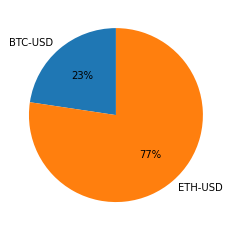

In [56]:
labels = [i for i in cleaned_weights.keys() if cleaned_weights[i] != 0]
sizes = [i for i in cleaned_weights.values() if i != 0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.0f%%',
        shadow=False, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [62]:
ef.portfolio_performance(verbose=True)

Expected annual return: 21.3%
Annual volatility: 72.8%
Sharpe Ratio: 0.27


(0.21290700624086895, 0.7278617188610833, 0.2650324934559258)

Crypto trading allow for fraction buy/sell of currencies. so we dont need discrete allocation of coins.

### Risk Averse portfolio

In [63]:
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('BTC-USD', 0.00999), ('ETH-USD', 0.00647), ('USDT-USD', 0.98354)])


In [64]:
ef.portfolio_performance(verbose=True)

Expected annual return: 0.2%
Annual volatility: 8.6%
Sharpe Ratio: -0.21


(0.0020387934936875545, 0.08628955622090602, -0.20815041000246623)

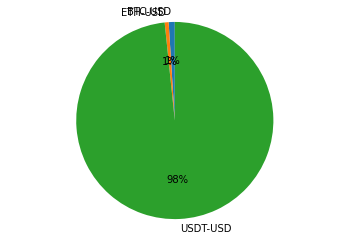

In [66]:
labels = [i for i in cleaned_weights.keys() if cleaned_weights[i] != 0]
sizes = [i for i in cleaned_weights.values() if i != 0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.0f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<AxesSubplot:xlabel='Date'>

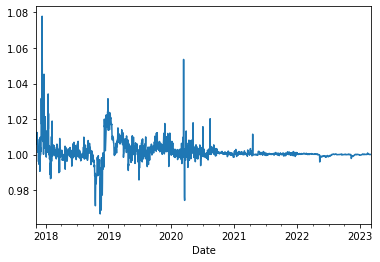

In [67]:
data['USDT-USD'].plot()

## Machine Learning solution

In [ ]:
#  Tree Based Model

## Deep Learning Solution

In [ ]:
# https://www.quantconnect.com/terminal/processCache/?request=embedded_backtest_4ebbe01bfea8c5ae6f98fcda38a50b1c.html

# Streamlit App

In [ ]:
# Design
#  3 pages app
## page 1: choose (portfolio, budget, horizon)
## page 2: basic EDA (history, volatility...)
## page 3: portfolio ratio/profits/probabilities

# Conclusion

Beyond the App
- Portfolio builder App

# References
[Getting Crypto Symbols](https://stackoverflow.com/a/74656748)

[Portfolio Optimization Using Python](https://github.com/areed1192/portfolio-optimization/blob/master/samples/portfolio_optimization.ipynb)

[Portfolio Builder](https://github.com/yeungadrian/PortfolioBuilder)

[Portfolio Selection with Graph Algorithms and Deep Learning](https://www.linkedin.com/pulse/portfolio-selection-graph-algorithms-deep-learning-maya-benowitz)

[G-Research Crypto Forecasting](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview)

[G-Research Crypto Forecasting](https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition/notebook#Preprocessing)

[yfinance guide](https://www.qmr.ai/yfinance-library-the-definitive-guide/#Fetch_Historical_Prices_using_yfinance
)

[Portfolio Optimization with PyPortfolioOpt](https://github.com/paulsg3/PortfolioOptimization/blob/main/Portfolio_Optimization.ipynb)

[PyPortfolioOpt Documentation](https://pyportfolioopt.readthedocs.io/en/latest/)

[Portfolio Optimization using Reinforcement Learning](https://github.com/kvsnoufal/portfolio-optimization)

[Multi-level Columns](https://stackoverflow.com/a/56080234)

[On the non-stationarity of financial time series: Impact on optimal portfolio selection](https://www.researchgate.net/publication/224905259_On_the_non-stationarity_of_financial_time_series_Impact_on_optimal_portfolio_selection)

[Stationary TS](https://analyticsindiamag.com/how-to-make-a-time-series-stationary/)

[Volatility Analysis](https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/)

[Volatility Analysis](https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/)